## Build an waste classifier

In this project, we trained a convolutional neural network to classify an image as either cardboard, glass, metal, paper, plastic, or trash with the fastai library (built on PyTorch). 

Dataset : Dataset collected manually by Gary Thung and Mindy Yang : https://github.com/garythung/trashnet/blob/master/data/dataset-resized.zip to follow along, then moved it to the same directory as this notebook.

#### Pipeline:

1. Download and extract the images
2. Organize the images into different folders
3. Train model
4. Make and evaluate test predictions
5. Next steps

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

## 1. Extract data

First, we need to extract the contents of "dataset-resized.zip".

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
files = zf.ZipFile(os.path.join(os.getcwd(),'drive/My Drive/Colab Notebooks/dataset-resized.zip'),'r')
files.extractall()
files.close()

Once unzipped, the dataset-resized folder has six subfolders:

In [7]:
os.listdir(os.path.join(os.getcwd(),'dataset-resized'))

['trash', 'paper', 'glass', '.DS_Store', 'metal', 'plastic', 'cardboard']

## 2. Organize images into different folders

Now that we've extracted the data, we split images up into train, validation, and test image folders with a 50-25-25 split.

In [0]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

Next, we created a bunch of destination folders according to the ImageNet directory convention. It'll look like this:

/data <br>
&nbsp;&nbsp;&nbsp;&nbsp; /train <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /cardboard <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /glass <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /metal <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /paper <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /plastic <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /trash <br>
&nbsp;&nbsp;&nbsp;&nbsp; /valid <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /cardboard <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /glass <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /metal <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /paper <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /plastic <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /trash <br>
&nbsp;&nbsp;&nbsp;&nbsp;/test <br>

Each image file is just the material name and a number (i.e. cardboard1.jpg)

In [0]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

We set the seed for both random samples to be 1 for reproducibility. Now that the data's organized, we can get to model training.

In [10]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [0]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

The batch size bs is how many images you'll train at a time.

You can use get_transforms() function to augment your data. I'll compare the results from flipping images horizontally and vertically.

In [12]:
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
trash,trash,trash,trash,trash
Path: /content/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
trash,trash,trash,trash,trash
Path: /content/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data

In [13]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


Here's an example of what the data looks like:

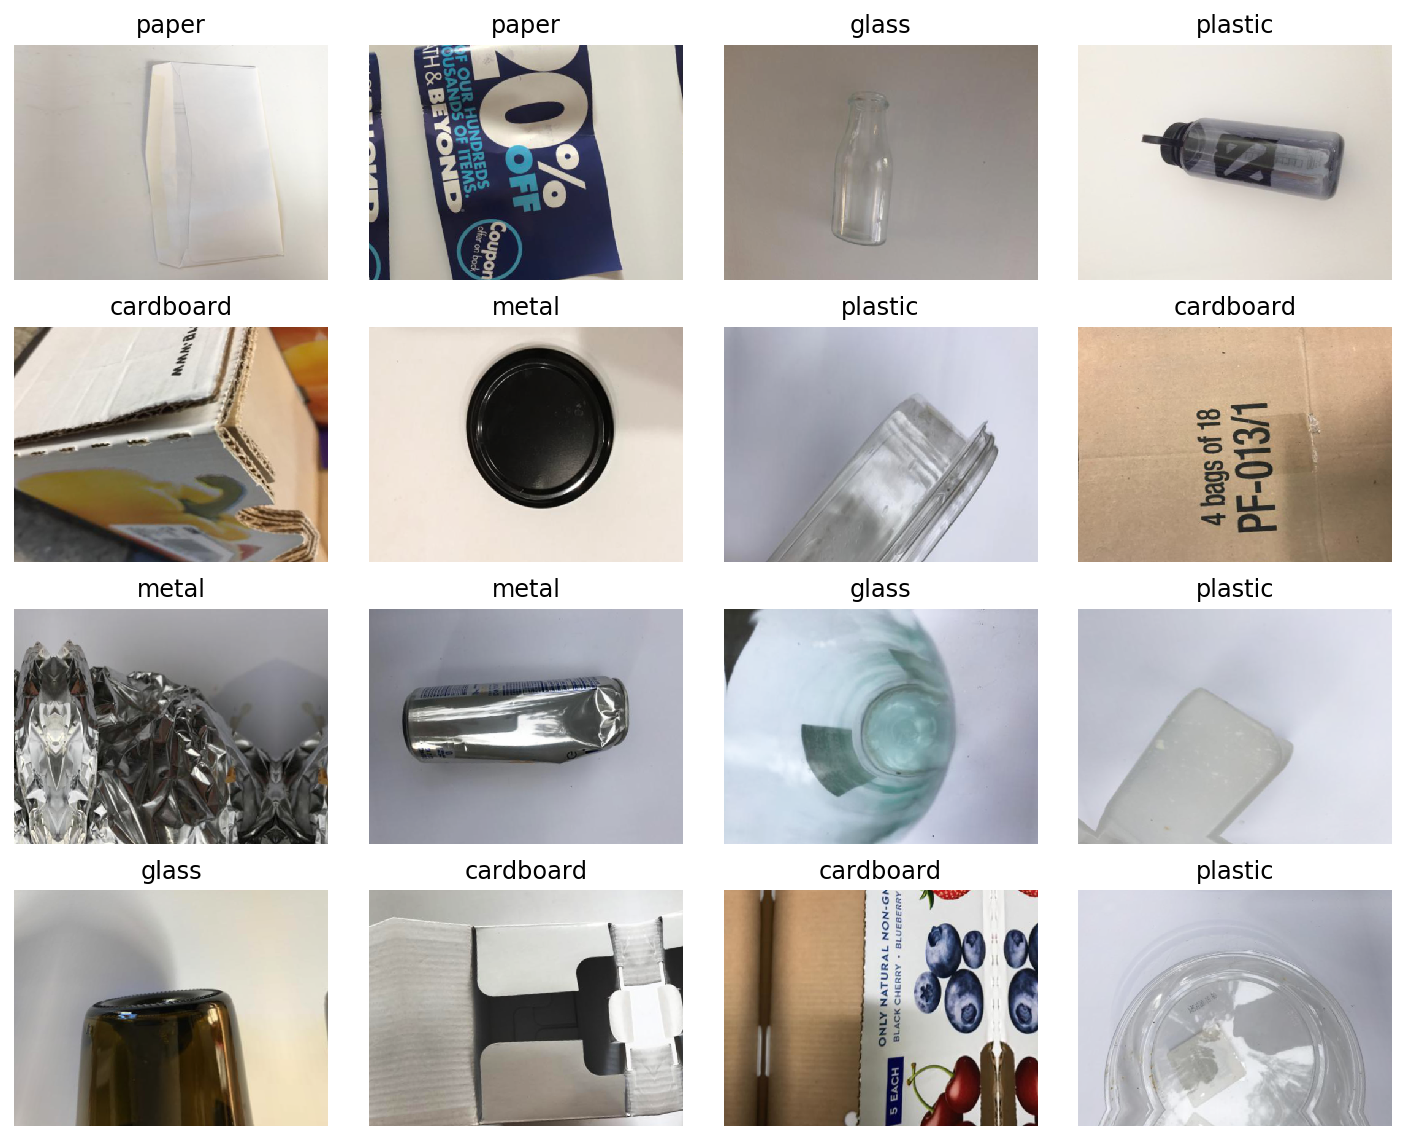

In [15]:
data.show_batch(rows=4,figsize=(10,8))

## 3. Model training

Download Resnet34 model

In [0]:
learn = cnn_learner(data,models.resnet34,metrics=error_rate)

### Resnet34?

A residual neural network is a [convolutional neural network (CNN)](https://towardsdatascience.com/convolutional-neural-networks-for-beginners-practical-guide-with-python-and-keras-dc688ea90dca) with lots of layers. In particular, resnet34 is a CNN with 34 layers that's been pretrained on the [ImageNet database](http://www.image-net.org/). A pretrained CNN will perform better on new image classification tasks because it has already learned some visual features and can transfer that knowledge over (hence transfer learning).

In [24]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

### Find a learning rate

With lr_find method we found a learning rate for gradient descent to make sure that neural network converges reasonably quickly without missing the optimal error. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-03
Min loss divided by 10: 2.19E-03


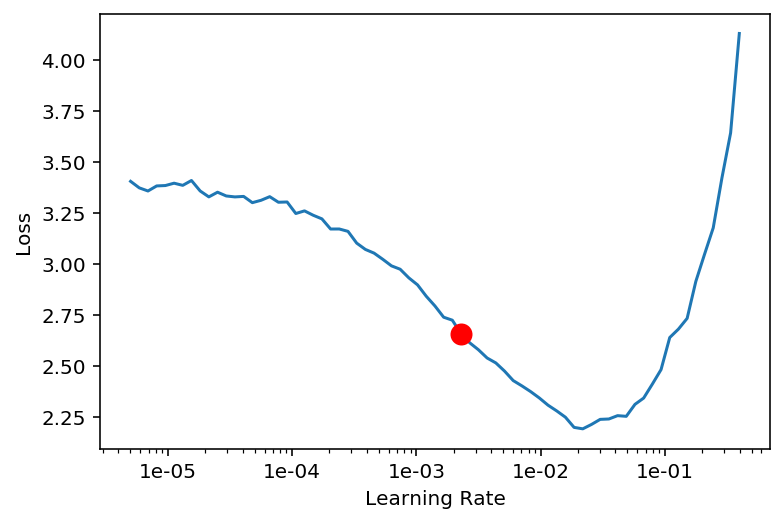

In [25]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot(suggestion=True)

The learning rate finder suggests a learning rate of 2.29E-03. With this, we can train the model.

### Training

In [26]:
learn.fit_one_cycle(20,max_lr=2.29E-03)

epoch,train_loss,valid_loss,error_rate,time
0,2.039539,0.984560,0.382540,00:49
1,1.341594,0.552658,0.187302,00:49
2,0.913620,0.482236,0.157143,00:48
3,0.813689,0.520088,0.169841,00:48
4,0.751243,0.493915,0.165079,00:49
5,0.673179,0.531132,0.176190,00:49
6,0.556506,0.374184,0.130159,00:49
7,0.550973,0.358145,0.125397,00:49
8,0.470150,0.320658,0.103175,00:49
9,0.389675,0.293567,0.098413,00:49


We ran the model for 20 epochs. The error rate 6.5% looks super good. Let's see how it performs on the test data though. 

First, we can take a look at which images were most incorrectly classified.

### VIsualizing most incorrect images

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

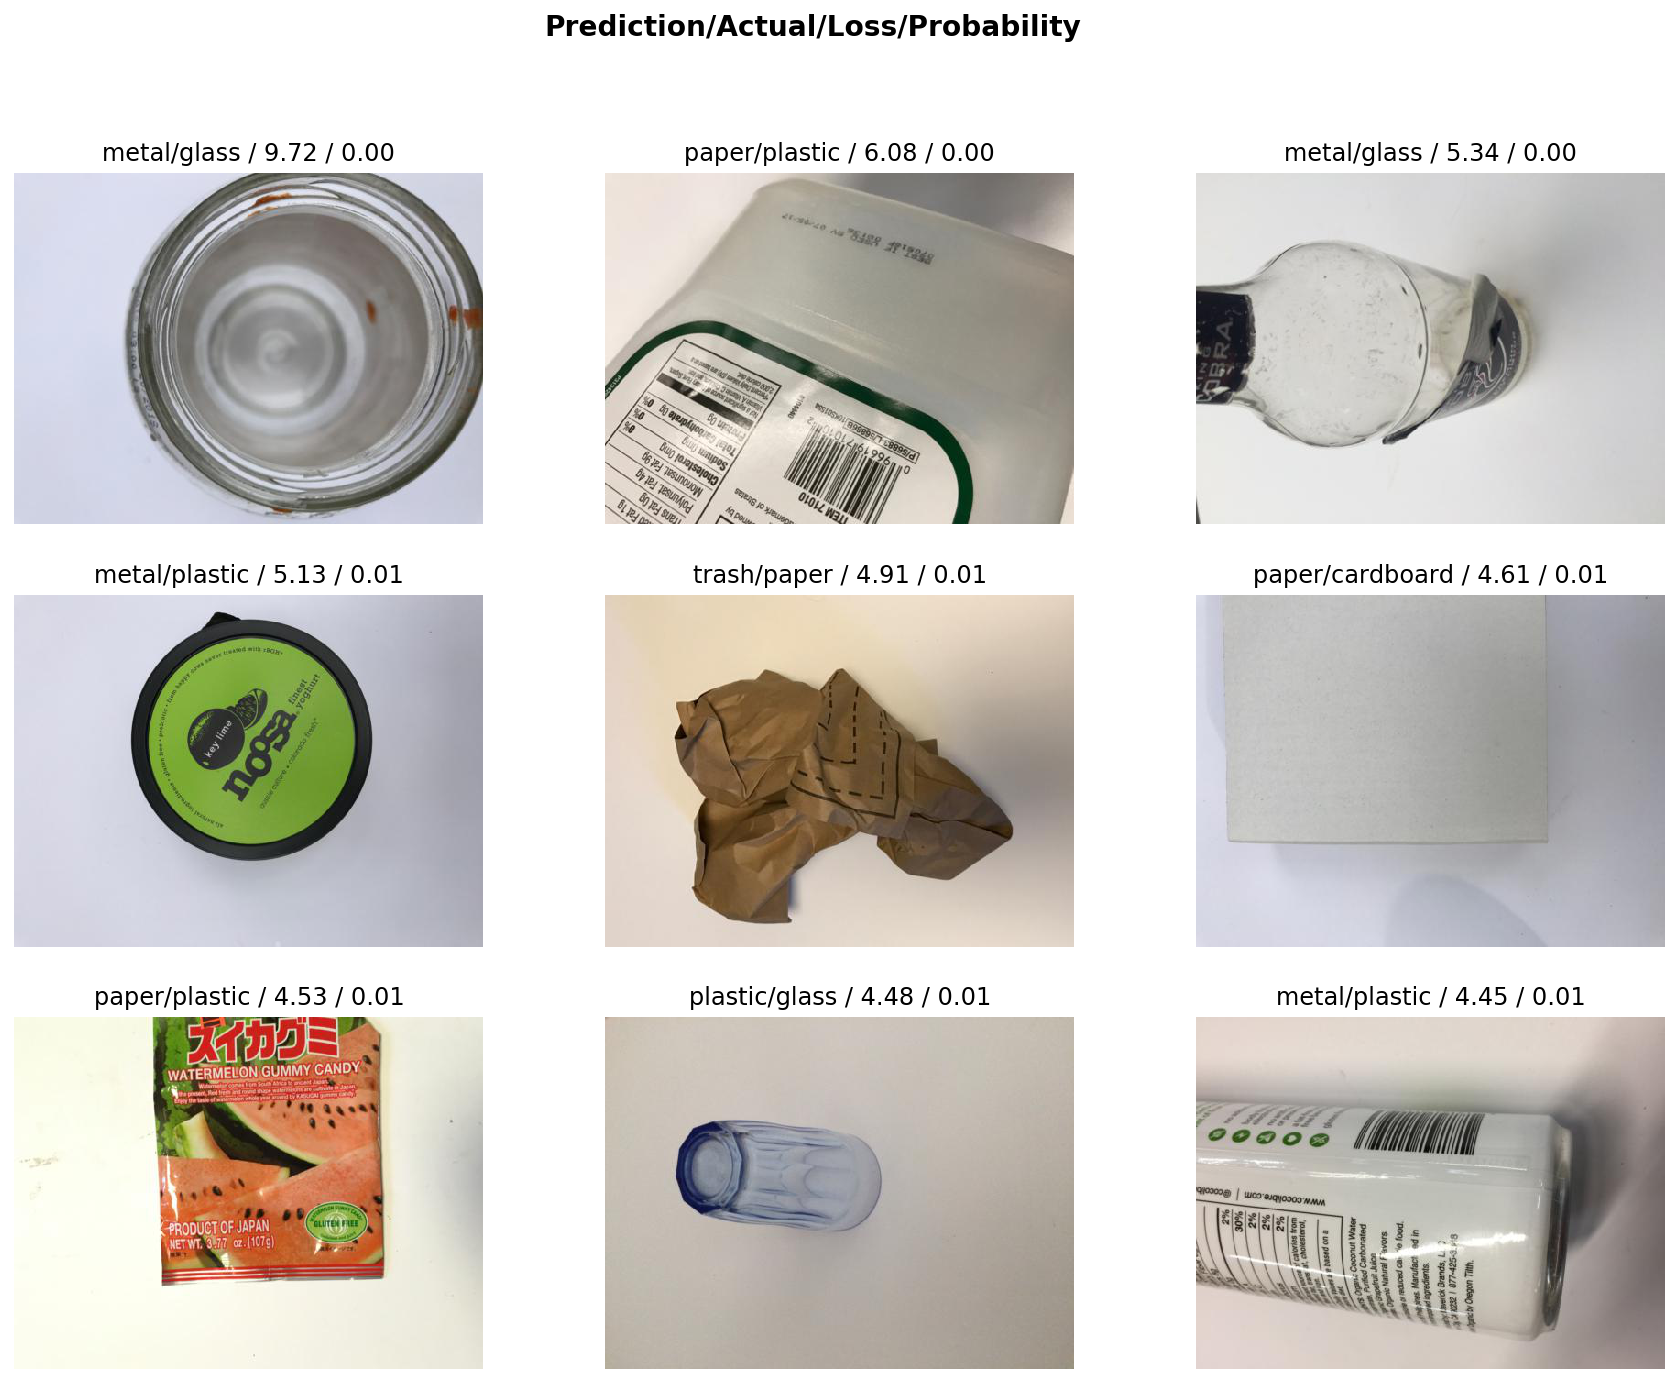

In [28]:
interp.plot_top_losses(9, figsize=(15,11))

The images here that the recycler performed poorly on were actually degraded. It looks the photos received too much exposure or something so this actually isn't a fault with the model!

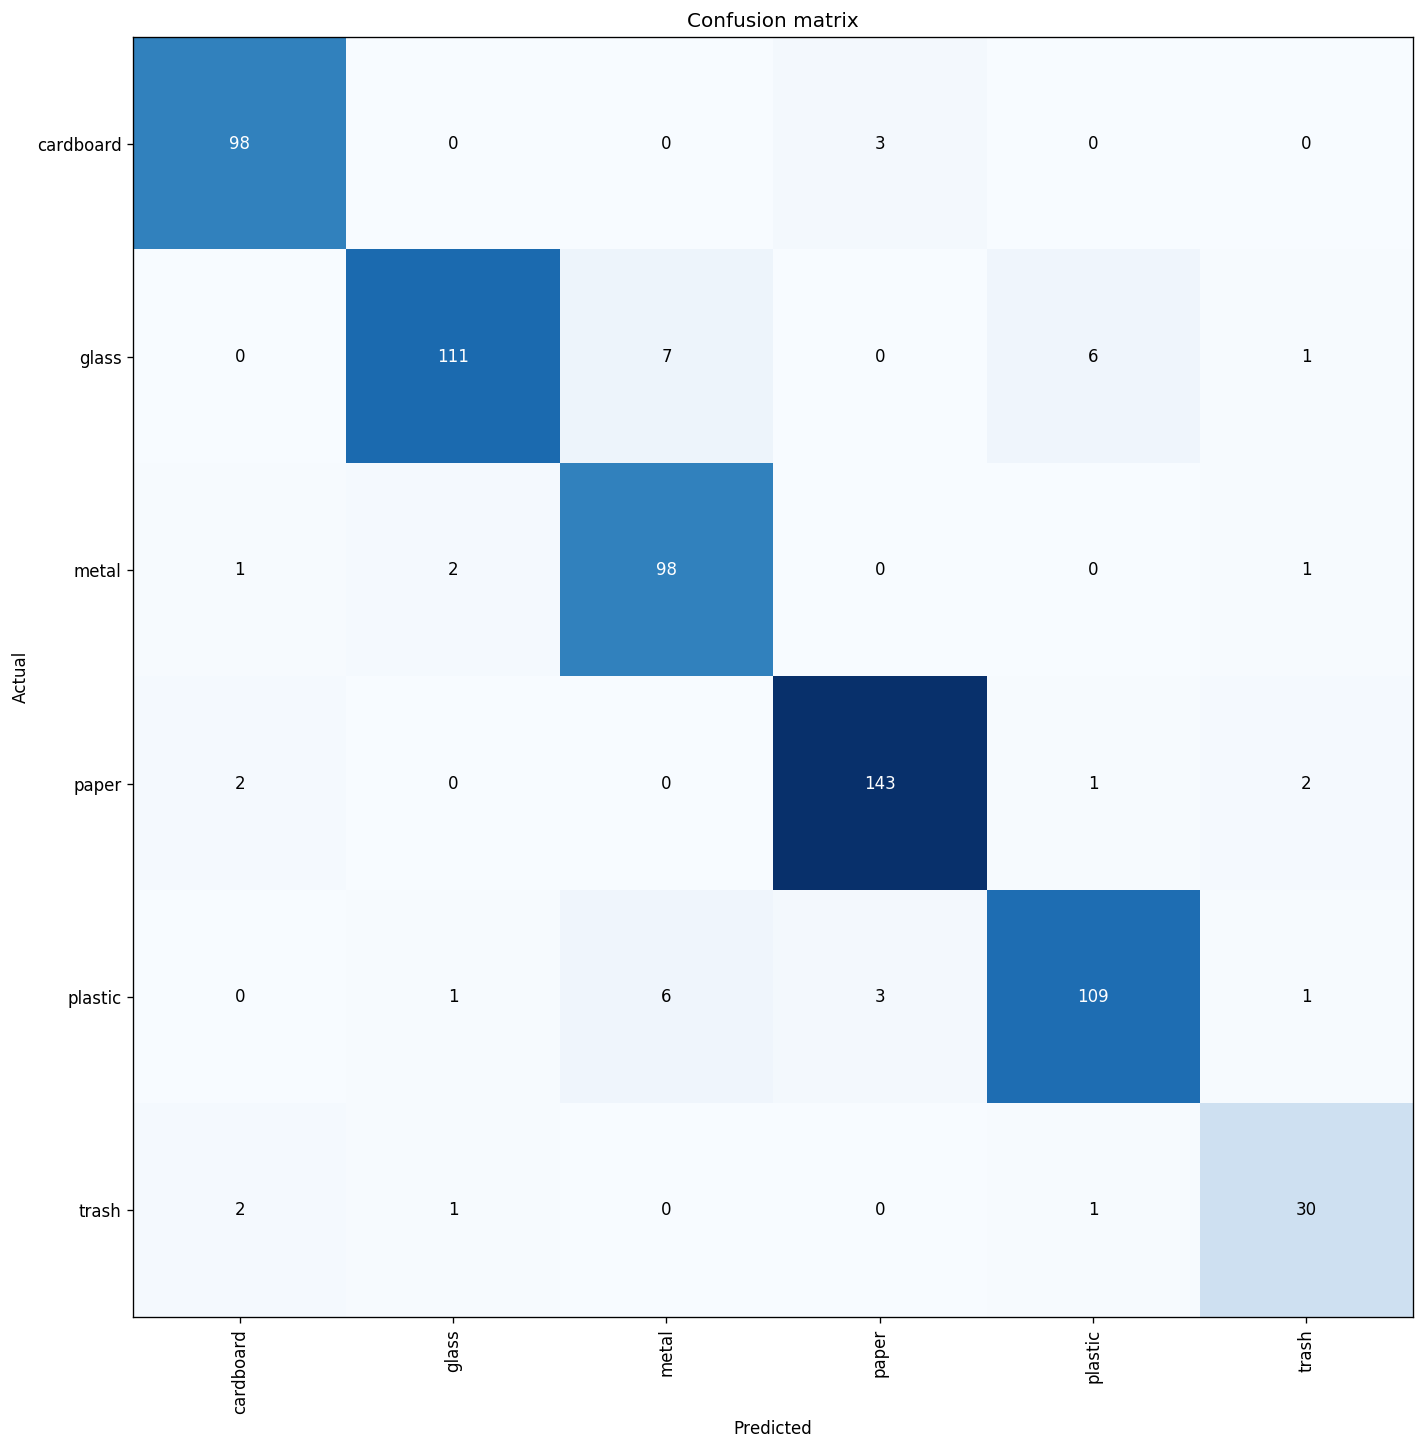

In [29]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

This model often confused plastic for glass and confused metal for glass. The list of most confused images is below.

In [30]:
interp.most_confused(min_val=2)

[('glass', 'metal', 7),
 ('glass', 'plastic', 6),
 ('plastic', 'metal', 6),
 ('cardboard', 'paper', 3),
 ('plastic', 'paper', 3),
 ('metal', 'glass', 2),
 ('paper', 'cardboard', 2),
 ('paper', 'trash', 2),
 ('trash', 'cardboard', 2)]

## 4. Make new predictions on test data

To see how this mode really performs, we need to make predictions on test data. First, we'll make predictions on the test data using the learner.get_preds() method. 

In [0]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [33]:
print(preds[0].shape)
preds[0]

torch.Size([635, 6])


tensor([[9.9748e-01, 1.1945e-04, 2.0640e-03, 1.0595e-05, 2.8696e-04, 3.9686e-05],
        [9.9945e-01, 1.3766e-06, 1.9149e-05, 5.0783e-04, 2.0979e-05, 1.3540e-06],
        [1.2855e-06, 1.4150e-02, 1.3235e-04, 2.8257e-08, 9.8571e-01, 9.8309e-06],
        ...,
        [5.3660e-06, 6.9559e-01, 1.1765e-01, 7.7515e-05, 1.8666e-01, 1.2432e-05],
        [5.6515e-05, 2.5949e-01, 3.0724e-03, 1.3429e-05, 7.3686e-01, 5.0521e-04],
        [1.0000e+00, 9.3198e-10, 4.1584e-08, 1.9159e-06, 2.5700e-12, 2.7059e-08]])

These are the predicted probablities for each image. This tensor has 635 rows -- one for each image -- and 6 columns -- one for each material category.

In [34]:
data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

Now I'm going to convert the probabilities in the tensor above to a string with one of the class names.

In [0]:
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [0]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [37]:
yhat

['cardboard',
 'cardboard',
 'plastic',
 'paper',
 'plastic',
 'metal',
 'metal',
 'plastic',
 'cardboard',
 'plastic',
 'cardboard',
 'paper',
 'glass',
 'plastic',
 'cardboard',
 'plastic',
 'metal',
 'glass',
 'metal',
 'cardboard',
 'cardboard',
 'cardboard',
 'paper',
 'metal',
 'plastic',
 'paper',
 'plastic',
 'cardboard',
 'plastic',
 'plastic',
 'glass',
 'plastic',
 'metal',
 'cardboard',
 'paper',
 'plastic',
 'plastic',
 'cardboard',
 'glass',
 'plastic',
 'metal',
 'paper',
 'glass',
 'plastic',
 'paper',
 'metal',
 'metal',
 'paper',
 'glass',
 'metal',
 'glass',
 'paper',
 'plastic',
 'cardboard',
 'paper',
 'glass',
 'glass',
 'paper',
 'cardboard',
 'metal',
 'plastic',
 'cardboard',
 'trash',
 'glass',
 'metal',
 'plastic',
 'glass',
 'cardboard',
 'paper',
 'glass',
 'cardboard',
 'cardboard',
 'metal',
 'paper',
 'cardboard',
 'metal',
 'paper',
 'glass',
 'plastic',
 'metal',
 'plastic',
 'plastic',
 'metal',
 'glass',
 'paper',
 'cardboard',
 'cardboard',
 'plasti

These are the predicted labels of all the images! Let's check if the first image is actually glass.

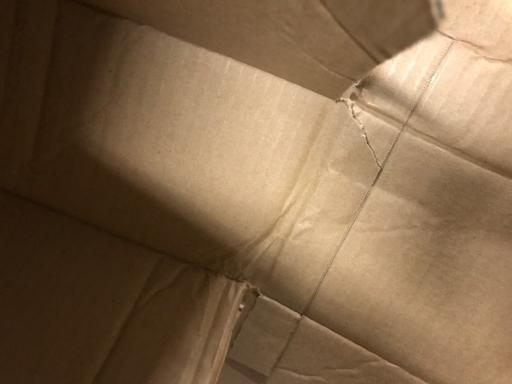

In [38]:
learn.data.test_ds[0][0]

It is!

Next, I'll get the actual labels from the test dataset.

In [0]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

A quick check.

In [40]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['cardboard', 'cardboard', 'plastic', 'paper', 'plastic']
['cardboard', 'cardboard', 'plastic', 'paper', 'plastic']


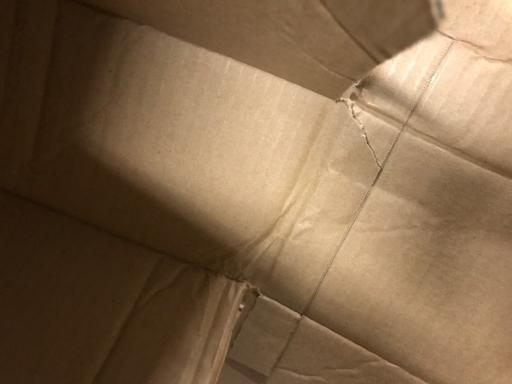

In [42]:
learn.data.test_ds[0][0]

It looks the first five predictions match up! (check)

How did we end up doing? Again we can use a confusion matrix to find out.

### Test confusion matrix

In [43]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 97   0   0   4   0   0]
 [  0 110  10   0   6   0]
 [  3   5  94   0   0   1]
 [  1   0   1 145   0   2]
 [  0   4   0   0 114   3]
 [  1   0   3   1   3  27]]


Let's try and make this matrix a little prettier.

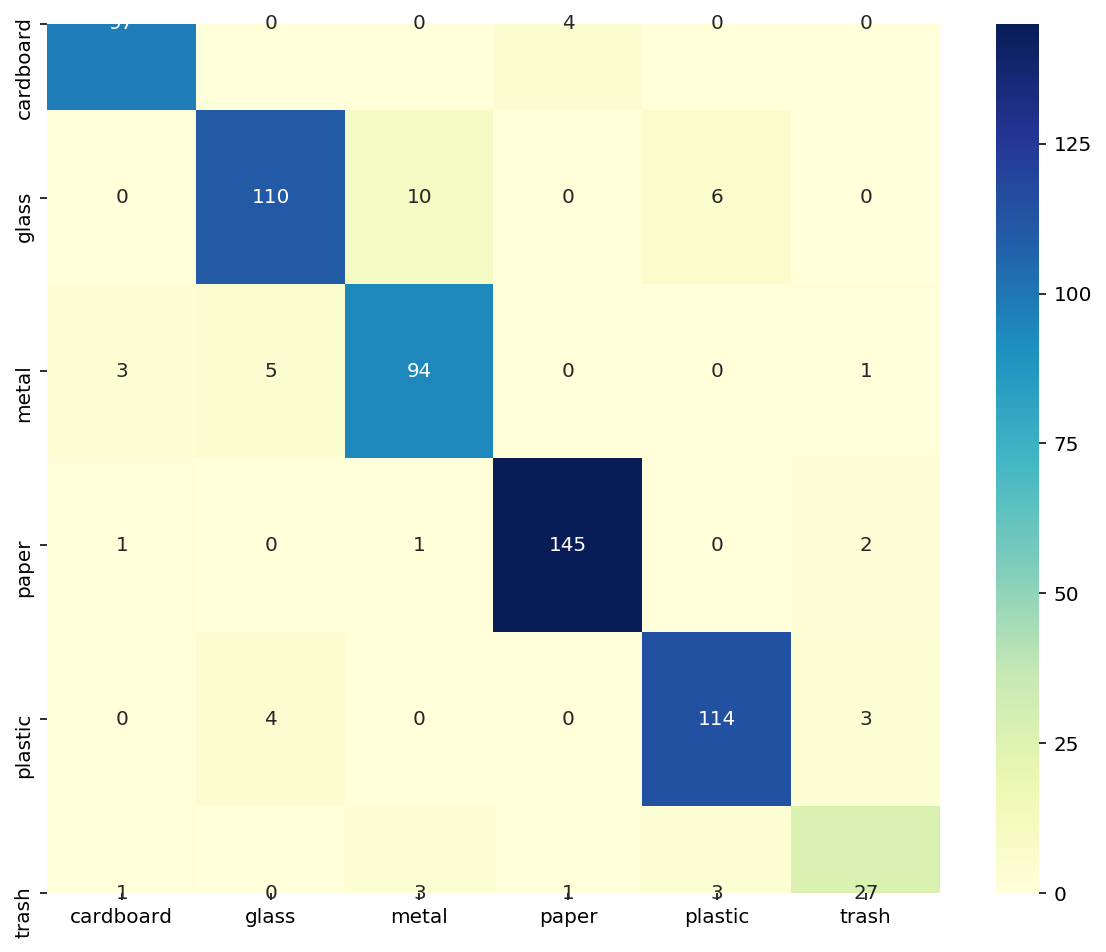

In [44]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

Again, the model seems to have confused metal for glass and plastic for glass. With more time, I'm sure further investigation could help reduce these mistakes.

In [0]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [46]:
accuracy = correct/sum(sum(cm))
accuracy

0.9244094488188976

We ended up achieving an accuracy of 92.4% on the test data which is pretty great -- the original creators of the TrashNet dataset achieved [a test accuracy of 63%](http://cs229.stanford.edu/proj2016/poster/ThungYang-ClassificationOfTrashForRecyclabilityStatus-poster.pdf) with a support vector machine on a 70-30 test-train split (they trained a neural network as well for a test accuracy of 27%).

In [0]:
## delete everything when you're done to save space
shutil.rmtree("data")
shutil.rmtree('dataset-resized')